### MIE 1624: Introduction to Data Science and analytics

The aim of this assignment is to work on 2019 election related tweets and predict the sentiment of the tweet corresponding to respective political parties based on the best model tuned on a generic tweets data with given target sentiments.

For this we follow below steps
Part1:
1. Import required libraries and create a dataframe of the CSV file
2. Cleaning the "Generic text"data
3. Perform analysis on the cleaned data to identify the correlation, trends required to predict sentiment
4. Using different word frequency techiques like "Bag of words", "Tf-Idf" prepare data for modelling 
5. Implement various models like Logistic Regression, Random Forest, KNN to predict the sentiment of test data
6. Once the model is done, we check for accuracy and analyse predicted vs actual results
7. List out any inferences gained from the study

## Importing required libraries and creating Datasets

In [1]:
#Downloading required packages
!pip install wordcloud
!pip install gensim
!pip install xgboost

In [2]:
#Importing necessary packages, functions 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import seaborn as sns
from wordcloud import WordCloud
import re
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
try:
    from gensim.models import word2vec
except:

    from gensim.models import word2vec
nltk.download("stopwords")
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sriram\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Importing Generic tweets DataSet

In [3]:
#Importing tweets data other files into dataframes
generic_tweets = pd.read_csv('generic_tweets.txt', sep=",")
stop_df = pd.read_csv('stop_words.txt', header=None)
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
#Checking for any nan values
generic_tweets.isna().sum()

class    0
id       0
date     0
query    0
user     0
text     0
dtype: int64

In [5]:
gb=generic_tweets.groupby(['class'])
gb.groups

{0: Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                 9,
             ...
             99990, 99991, 99992, 99993, 99994, 99995, 99996, 99997, 99998,
             99999],
            dtype='int64', length=100000),
 4: Int64Index([100000, 100001, 100002, 100003, 100004, 100005, 100006, 100007,
             100008, 100009,
             ...
             199990, 199991, 199992, 199993, 199994, 199995, 199996, 199997,
             199998, 199999],
            dtype='int64', length=100000)}

It is observed that there are two groups 0(negative emotion) and 4(positive emotion) with 100000 entries in each category.
1st 100000 are of negative emotion and the rest are of positive emotion

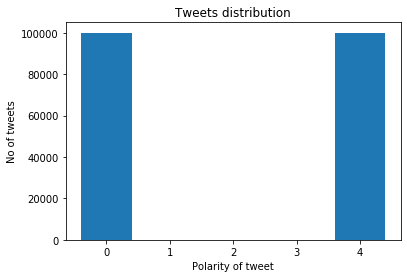

In [6]:
plt.bar(generic_tweets['class'].unique(),height=generic_tweets['class'].value_counts())
plt.xlabel('Polarity of tweet')
plt.ylabel('No of tweets')
plt.title('Tweets distribution')
plt.show()

### Importing election data set

In [7]:
#Importing election tweets file
elec_tweets=pd.read_csv('Canadian_elections_2019.csv')
elec_tweets.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [8]:
elec_tweets['sentiment_coded']=[0 if elec_tweets['sentiment'][i]=='negative' else 4 for i in range(len(elec_tweets))]
elec_tweets.head()

,sentiment,negative_reason,text,sentiment_coded
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",0
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",4
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",0
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",4
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",0


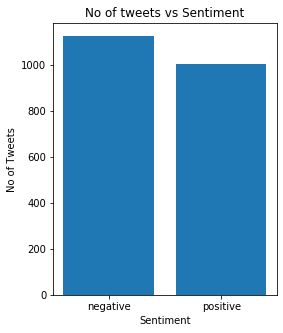

In [9]:
plt.figure(figsize=(4,5))
plt.bar(elec_tweets['sentiment'].unique(),elec_tweets['sentiment'].value_counts())
plt.title('No of tweets vs Sentiment')
plt.ylabel('No of Tweets')
plt.xlabel('Sentiment')
plt.show()

There are more negetive tweets than positive, in the dataset collected. It might be due to general tendency of people with dissatisfaction putting their words into action more often.  

## Data cleaning

### Generic tweets

In [10]:
generic_tweets['text'][0:10]

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
5                        @Kwesidei not the whole crew 
6                                          Need a hug 
7    @LOLTrish hey  long time no see! Yes.. Rains a...
8                 @Tatiana_K nope they didn't have it 
9                            @twittera que me muera ? 
Name: text, dtype: object

The tweets contains unnecessary information that creates noise. So below items are removed from text
    1. User tag with '@' - We use regular expression library and replace text that starts with '@' with white spaces. Along woth this, all non-alphabetic charecters like [],<>;:'"?/\|{} #! are also not required for analysis

    2. Web links and addresses like https:// and tags - There are various functions to perform this. We can use RE library same as above step or use additional libraries like beautiful soup.BS process is explained in next markdown

    3. Capital and lower case letters- We convert all alphabets to lower case

    4. Stop words using the list provided- Many words such as {articles-a,an,the, prepositions-to,from,below,above and other general words like pronouns-He,She,It,They and all are not required for analysis} NLTK library has default list of stop words for each language. We can import and use the list. Also stop words list provided for this assignment is also used

    5. Convert the text to stem words- There are various stem methods like porterstemmer, snowball stemmer, lancaster stemmer. PorterStemmer is known for its simplicity and speed.LancasterStemmer is simple, but heavy stemming due to iterations and over-stemming may occur. Over-stemming causes the stems to be not linguistic, or they may have no meaning.
    

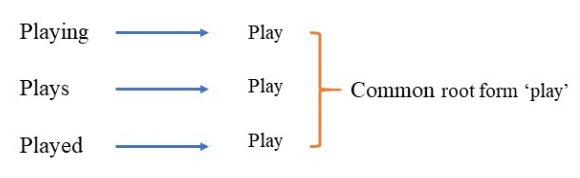

Beautiful soup has two options namely, html5lib, lxml

html5lib: It uses HTML5 parsing algorithm, it even fixes lots of broken HTML and adds several tags which are missing in order to complete the text and make it look like an HTML doc but it is extremely Lenient and Very Slow because it’s backed by lots of Python Code.

lxml: Very Fast because it’s backed by lots of Cython code and Fixes some broken HTML, but doesn’t work enough in order to present it like a complete HTML doc. Quite lenient.

In [11]:
#Checking working of beautiful soup
print('Input is:\n{}\n'.format(generic_tweets['text'][343]))

import time
start_time = time.time()
xxx=BeautifulSoup(generic_tweets['text'][343], 'lxml').get_text()
print('Using lxml:\n{}'.format(xxx))
finish_time=time.time()
print("--- %s seconds ---\n\n" % (finish_time - start_time))

start_time = time.time()
xxx=BeautifulSoup(generic_tweets['text'][343], 'html5lib').get_text()
print('Using html5lib:\n{}'.format(xxx))
finish_time=time.time()
print("--- %s seconds ---" % (finish_time - start_time))

Input is:
@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down 

Using lxml:
@TheLeagueSF Not Fun & Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted & clamped down 
--- 0.0 seconds ---


Using html5lib:
@TheLeagueSF Not Fun & Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted & clamped down 
--- 0.0 seconds ---


#### Even though both are performing the same task, html5lib processing time is 4 times that of lxml

In [12]:
#Cleaning the unwanted information from text data
def clean(text):
    list_lc = []
    s1 = ' '
    corpus_clean = []
    for line in text:
    
        #Bring all text to lowercase 
        lower_case = line.lower()
        list_lc.append(lower_case)
    
        #Removing web addresses with www and http and single alphabets, Tweet id's (@xxxx)
        lower_case=re.sub(r"http\S+", "", lower_case)
        lower_case=re.sub(r"www.\S+", "", lower_case)
        lower_case=re.sub(r'@[_A-Za-z0-9]+','',lower_case)

        #Removing HTML tags
        lower_case=lower_case.replace("\\n", "")
        lower_case=(lower_case.encode('ascii', 'ignore')).decode("utf-8") #to remove emojis byte codes
        lower_case = re.sub(r"[,@\?\\.$%_\\\']", "", lower_case)
        lower_case=BeautifulSoup(lower_case, 'lxml').get_text()

        #Splitting sentences into words using tokens
        tokenizer = RegexpTokenizer(r'\w+')         
        b = tokenizer.tokenize(lower_case)

        #Removing stop words
        words_rmStop = [word for word in b if word not in stopwords.words('english')]
        words_rmStop = [word for word in words_rmStop if word not in stop_df]

        #Converting words to root(stem) words
        ps = PorterStemmer()
        words_stem = [ps.stem(word) for word in words_rmStop] # stem 
        corpus_clean.append(s1.join(words_stem))
    return(corpus_clean)

In [13]:
generic_tweets_cleaned=generic_tweets[['class','text']]
generic_tweets_cleaned['cleaned_text']=clean(generic_tweets['text'])
generic_tweets_cleaned.tail()

,class,text,cleaned_text
199995,4,"@jvdouglas haha, no, the remark on maternity ...",haha remark matern leav fire littl
199996,4,@altitis and to you!,
199997,4,Okie doke!! Time for me to escape for the Nort...,oki doke time escap north massa back turn get ...
199998,4,"finished the lessons, hooray!",finish lesson hooray
199999,4,Some ppl are just fucking KP0. Cb ! Stop askin...,ppl fuck kp0 cb stop ask laa love boyfriend that


In [14]:
generic_tweets_cleaned['pre_length']=[len(generic_tweets_cleaned['text'][i]) for i in range(len(generic_tweets_cleaned))]
generic_tweets_cleaned['post_length']=[len(generic_tweets_cleaned['cleaned_text'][i]) for i in range(len(generic_tweets_cleaned))]

In [15]:
generic_tweets_cleaned.head()

,class,text,cleaned_text,pre_length,post_length
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that bummer shoulda got david carr third day,115,49
1,0,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...,111,70
2,0,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save 50 rest go bound,89,47
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire,47,31
4,0,"@nationwideclass no, it's not behaving at all....",behav im mad cant see,111,21


### Election data set

Cleaning of election data set is done in two parts since we need to use twitter id's and #tags for classification of tweets to respective political parties. Part 1 does preliminary cleaning like case conversion, html tags removal, emoji's unicode removal and part 2 does deep cleaning like # tags, twitter id's, tokenizing and stemming.  

In [16]:
#Checking for any missing entries
elec_tweets.isna().sum()

sentiment             0
negative_reason    1126
text                  0
sentiment_coded       0
dtype: int64

Reason is provided only for negetive tweets. Hence the nan values are left as such without filling up

In [17]:
#Basic Cleaning for data exploration (excluding tweet id's and # tags)
def clean1(text):
    list_lc = []
    s1 = ' '
    corpus_clean = []
    for line in text:
    
        #Bring all text to lowercase 
        lower_case = line.lower()
        list_lc.append(lower_case)
    
        #Removing web addresses
        lower_case=re.sub(r"http\S+", "", lower_case)
        
        #Removing HTML tags and unwanted tags like new line charecters
        lower_case=lower_case[2:-1]
        lower_case=" ".join(filter(lambda x:x[0]!='\\', lower_case.split()))
        lower_case=(lower_case.encode('ascii', 'ignore')).decode("utf-8")
        lower_case=lower_case.replace("\\n", " ")
        lower_case = re.sub(r"[,\?\.$\\%_\\\']", "", lower_case)
        lower_case=BeautifulSoup(lower_case, 'lxml').get_text()

        corpus_clean.append(lower_case)
    return(corpus_clean)

In [18]:
elec_tweets['cleaned_text']=clean1(elec_tweets['text'])
elec_tweets.head()

,sentiment,negative_reason,text,sentiment_coded,cleaned_text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",0,@rosiebarton so instead of your suggestion how...
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",4,#allwomanspacewalk its real! @spacestation #ci...
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",0,#brantford its going to cost you 94 billion fo...
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",4,#canada #canadaelection2019 #canadavotes decid...
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",0,#canada #taxpayers are sick & tired of having ...


In [19]:
#Deep cleaning of unwanted information from text data for model implementation
def clean2(text):
    list_lc = []
    s1 = ' '
    corpus_clean = []
    for line in text:
    
        #Removing Tweet id's (@xxxx), #tags
        lower_case=re.sub(r'@[_A-Za-z0-9]+','',line)

        #Splitting sentences into words using tokens
        tokenizer = RegexpTokenizer(r'\w+')         
        b = tokenizer.tokenize(lower_case)

        #Removing stop words
        words_rmStop = [word for word in b if word not in stopwords.words('english')]
        words_rmStop = [word for word in words_rmStop if word not in stop_df[0]]

        #Converting words to root(stem) words
        ps = PorterStemmer()
        words_stem = [ps.stem(word) for word in words_rmStop] 
        corpus_clean.append(s1.join(words_stem))
    return(corpus_clean)

In [20]:
#Calling deep cleaning function for further cleaning of tweets
elec_model=elec_tweets['c_text']=clean2(elec_tweets['cleaned_text'])
elec_tweets.head()

,sentiment,negative_reason,text,sentiment_coded,cleaned_text,c_text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",0,@rosiebarton so instead of your suggestion how...,instead suggest agre canadian women trust andr...
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",4,#allwomanspacewalk its real! @spacestation #ci...,allwomanspacewalk real cityofto onpoli cdnpoli...
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",0,#brantford its going to cost you 94 billion fo...,brantford go cost 94 billion next 4 year ask j...
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",4,#canada #canadaelection2019 #canadavotes decid...,canada canadaelection2019 canadavot decid help
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",0,#canada #taxpayers are sick & tired of having ...,canada taxpay sick tire hard earn donat corpor...


## Exploratory Data Analysis

### Generic tweets

In [21]:
pos_tweets=generic_tweets_cleaned[generic_tweets_cleaned['class']==4]
neg_tweets=generic_tweets_cleaned[generic_tweets_cleaned['class']==0]

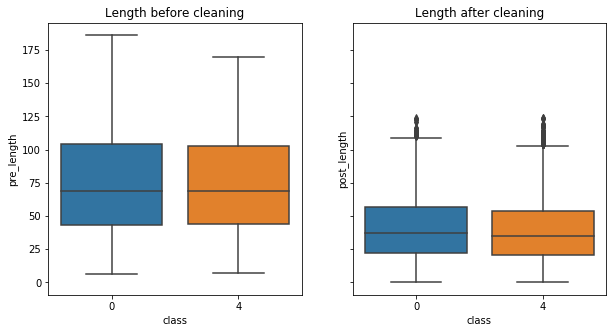

In [22]:
f, axes = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
sns.boxplot(x="class", y="pre_length",data=generic_tweets_cleaned, ax=axes[0])
axes[0].set_title('Length before cleaning')
sns.boxplot(x="class", y="post_length",data=generic_tweets_cleaned, ax=axes[1])
axes[1].set_title('Length after cleaning')
plt.show()

Length of the tweet is not a deciding feature for sentiment classification as the distribution of lengths of positive and negative tweets are almost the same before and after cleaning the unwanted text

In [23]:
pos_=[]
neg_=[]
for i in generic_tweets_cleaned.index:
    if generic_tweets_cleaned['class'][i]==0:
        neg_.append(generic_tweets_cleaned['cleaned_text'][i])
    else:
        pos_.append(generic_tweets_cleaned['cleaned_text'][i])

In [24]:
pos_tweet_con=pd.Series(pos_).str.cat(sep=' ')
neg_tweet_con=pd.Series(neg_).str.cat(sep=' ')

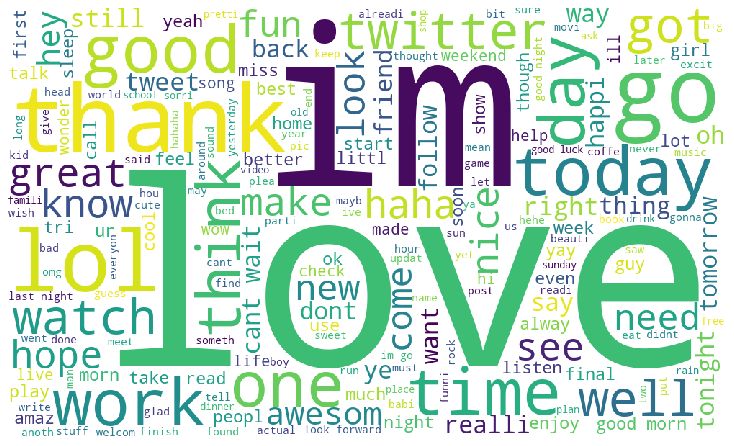

In [25]:
wordcloud = WordCloud(width = 1000, height = 600,background_color ='white',min_font_size = 10).generate(pos_tweet_con) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

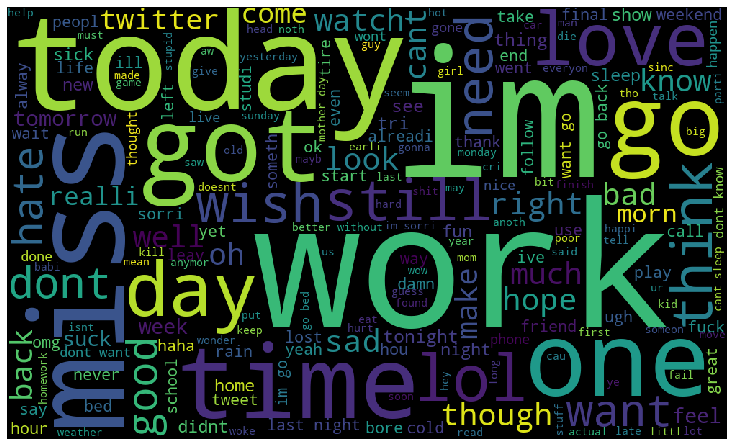

In [26]:
wordcloud = WordCloud(width = 1000, height = 600,min_font_size = 10).generate(neg_tweet_con) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

We can cross check our analysis using wordcloud. 

Here it is observed that in tweets with positive sentiment, words with positive feeling like Love, nice, thank, awesome, great, friend, cool are more frequent

where as in tweets with negative sentiment, words like sorri (root of sorry), miss, hate, sick, sad and other abusive words are more frequent.

Surprisingly love is more frequent than hate in negative sentiment tweets. Also work is more frequently used in both category of tweets.

### Election data set

Identifying the political party regarding which the tweet is about, cannot be done clearly as there are tweets which have spelling errors. But tags with user id's and hashtags can be taken into account to classify the party, the tweet is about.
Also, many tweets are mearly opinions about elections in Canada where multiple parties and its members were taged.They can be categorized into a seperate group.

Ideology followed:
1. Party official twitter id's, prime member twitter id's are gathered

    Example: Conservative party (@CPC_HQ), Prime member is Andrew Scheer (@AndrewScheer) 
2. #tags with the id's and id's themselves are filtered for a selected party and part of id's like only andrew and only scheer also for flexibility
3. Out of those, tweets containing id's and tags of other parties are removed

So, we will be left with tweet containing A and not B and not C.
##### Hence we compute (tweet in A and ~B and ~C =>A)

In [27]:
#Classification of tweets as per the #tags and twitter id's and grouping them as per political parties 
party_list=[]
party=''
for i in range(len(elec_tweets)):
    if(('conservative' in elec_tweets.cleaned_text[i]) or ('cpc' in elec_tweets.cleaned_text[i]) or ('andrew' in elec_tweets.cleaned_text[i]) or ('scheer' in elec_tweets.cleaned_text[i])) and (('liberal' not in elec_tweets.cleaned_text[i]) and ('justin' not in elec_tweets.cleaned_text[i]) and ('trudeau' not in elec_tweets.cleaned_text[i]) and ('lpc' not in elec_tweets.cleaned_text[i])) and (('ndp' not in elec_tweets.cleaned_text[i]) and ('jagmeet' not in elec_tweets.cleaned_text[i]) and ('democratic' not in elec_tweets.cleaned_text[i]) and ('singh' not in elec_tweets.cleaned_text[i])):
        party='conservative'
    elif (('conservative' not in elec_tweets.cleaned_text[i]) and ('cpc' not in elec_tweets.cleaned_text[i]) and ('andrew' not in elec_tweets.cleaned_text[i]) and ('scheer' not in elec_tweets.cleaned_text[i])) and (('liberal' in elec_tweets.cleaned_text[i]) or ('justin' in elec_tweets.cleaned_text[i]) or ('trudeau' in elec_tweets.cleaned_text[i]) or ('lpc' in elec_tweets.cleaned_text[i])) and (('ndp' not in elec_tweets.cleaned_text[i]) and ('jagmeet' not in elec_tweets.cleaned_text[i]) and ('democratic' not in elec_tweets.cleaned_text[i]) and ('democratic' not in elec_tweets.cleaned_text[i])):
        party='liberal'
    elif (('conservative' not in elec_tweets.cleaned_text[i]) and ('cpc' not in elec_tweets.cleaned_text[i]) and ('andrew' not in elec_tweets.cleaned_text[i]) and ('scheer' not in elec_tweets.cleaned_text[i])) and (('liberal' not in elec_tweets.cleaned_text[i]) and ('justin' not in elec_tweets.cleaned_text[i]) and ('trudeau' not in elec_tweets.cleaned_text[i]) and ('lpc' not in elec_tweets.cleaned_text[i])) and (('ndp' in elec_tweets.cleaned_text[i]) or ('jagmeet' in elec_tweets.cleaned_text[i]) or ('democratic' in elec_tweets.cleaned_text[i]) or ('democratic' in elec_tweets.cleaned_text[i])):
        party='ndp'
    else:
        party='none'
    party_list.append(party)

In [28]:
elec_tweets['political_party']=party_list
elec_tweets.head()

,sentiment,negative_reason,text,sentiment_coded,cleaned_text,c_text,political_party
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",0,@rosiebarton so instead of your suggestion how...,instead suggest agre canadian women trust andr...,conservative
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",4,#allwomanspacewalk its real! @spacestation #ci...,allwomanspacewalk real cityofto onpoli cdnpoli...,none
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",0,#brantford its going to cost you 94 billion fo...,brantford go cost 94 billion next 4 year ask j...,liberal
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",4,#canada #canadaelection2019 #canadavotes decid...,canada canadaelection2019 canadavot decid help,none
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",0,#canada #taxpayers are sick & tired of having ...,canada taxpay sick tire hard earn donat corpor...,liberal


In [29]:
elec_tweets.groupby(['political_party','sentiment']).count().text

political_party  sentiment
conservative     negative     327
                 positive     142
liberal          negative     160
                 positive     138
ndp              negative      40
                 positive     102
none             negative     479
                 positive     745
Name: text, dtype: int64

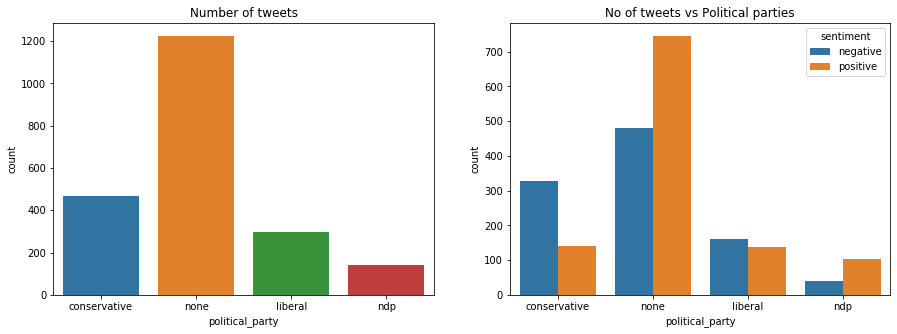

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

sns.countplot(x='political_party',data=elec_tweets, ax=ax1)
ax1.set_title('Number of tweets')

sns.countplot(x='political_party',hue='sentiment',data=elec_tweets, ax=ax2)
ax2.set_title('No of tweets vs Political parties')

plt.show()

It is observed that majority of tweets are either general comments about elections(calling people to vote, suggestions to create awareness among people about on going issues, various riots and threats, etc.,) or Refering to more than two parties. (Many tweets are refered to 2 or more parties which cannot be considered under 1 party)

43% of tweets are party specific tweets. Now we analyse the tweets excluding the none category, party wise based on sentiment

Out of the total tweets excluding that referring general elections, tweets referred to conservative party are more than that of liberal or NDP parties put together.

Leaving apart none category, Conservaive party has the maximum number of negative tweets where as NDP party has lowest. Negative tweets in conservative party are high as the total number of tweets referring the party are also high. So we can consider the ratio of posotive to negative tweets to generalise the people's sentiment towards a particular party.

positive to negative ratio:
    1. Conservative : 0.44
    2. Liberal      : 0.88
    3. NDP          : 2.38
  
From this ratio, we can see that People are positive towards NDP party, neutral to Liberal party and negative towards consevative party as the positive to negative tweets ratio is less than 1. But since the number of tweets are quite less for NDP, we can say that liberal party has more followers than NDP, and out of the three parties liberal party has maximum number of positive tweets which resulted in winning of this party in 2019 elections



## Model preparation & Implementation

Bag of Words is a word frequency algorithm that counts how many times a word appears in a document. We can use this counts to implement a model in textual analysis of any documents like news articles and tweets 

In [31]:
#Bag of words 
def bag(X):
    vectorizer1 = CountVectorizer(max_features =5000)
    X = vectorizer1.fit_transform(X)
    return(X)

Unlike bag of words, Tf-IDF doesnt use word count but instead words are given weight – TF-IDF measures relevance and wordcounts are replaced with TF-IDF scores across the whole dataset as per below formula
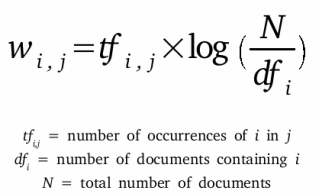

In [32]:
#TF-IDF
def tfidf(X):
    vectorizer2 = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features=5000)
    X = vectorizer2.fit_transform(X)
    return(X)

In [33]:
def model_(model,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=200, test_size=0.3)
    model.fit(X_train, y_train)
    predictions=model.predict(X_test)
    print('Report for {}:\n\n {}'.format(model,classification_report(y_test,predictions)))
    return(predictions,y_test)

Now that the data set is ready for model implementation, we apply various algorithms and compare the accuracy score to select the best model and the best model will be applied on election data to predict the sentiment of the tweets

We have choosen various models for comparision
    1. Logistic Regression : Since it is incredibly easy to implement and very efficient to train
    2. KNN : Very simple implementation, requires less or no training as it is based on distance between neighbours
    3. Random Forest : Training a large number of deep trees can have high computational costs and memory usage
    4. Decision tree classifier: A significant advantage of a decision tree is that it forces the consideration of all possible outcomes of a decision and traces each path to a conclusion
    5. SVM: SVM works relatively well when separation between classes is clear and more effective in high dimensional spaces
    6. XG boost: It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. 
    7. Naive bayes: It requires less training data. It is highly scalable. Can handle both discrete and continuous data

In [34]:
def allmodels(X,y):
    
    #Splitting into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=200, test_size=0.3)
    
    #Applying logistic regression
    model=LogisticRegression()
    model.fit(X_train, y_train)
    predictions=model.predict(X_test)
    acc_lr=round(accuracy_score(y_test,predictions)*100,2)
    print('Accuracy for Logistic regression model is {}%'.format(acc_lr))
    
    #Applying KNN classifier
    model=KNeighborsClassifier()
    model.fit(X_train, y_train)
    predictions=model.predict(X_test)
    acc_knn=round(accuracy_score(y_test,predictions)*100,2)
    print('Accuracy for KNN model is {}%'.format(acc_knn))
    
    #Applying random forest classifier
    model=RandomForestClassifier() 
    model.fit(X_train, y_train)
    predictions=model.predict(X_test)
    acc_rf=round(accuracy_score(y_test,predictions)*100,2)
    print('Accuracy for Random Forest model is {}%'.format(acc_rf))
    
    #Applying decission tree classifier
    model=DecisionTreeClassifier() 
    model.fit(X_train, y_train)
    predictions=model.predict(X_test)
    acc_dt=round(accuracy_score(y_test,predictions)*100,2)
    print('Accuracy for Decision tree model is {}%'.format(acc_dt))
    
    #Applying SVM
    model=LinearSVC() 
    model.fit(X_train, y_train)
    predictions=model.predict(X_test)
    acc_svm=round(accuracy_score(y_test,predictions)*100,2)
    print('Accuracy for SVM model is {}%'.format(acc_svm))
    
    #Applying XGboost
    model=xgb.XGBClassifier() 
    model.fit(X_train, y_train)
    predictions=model.predict(X_test)
    acc_xg=round(accuracy_score(y_test,predictions)*100,2)
    print('Accuracy for XGboost model is {}%'.format(acc_xg))
    
    #Applying naive bayes
    model=GaussianNB()
    model.fit(X_train.toarray(), y_train)
    predictions=model.predict(X_test.toarray())
    acc_nb=round(accuracy_score(y_test,predictions)*100,2)
    print('Accuracy for naive bayes model is {}%'.format(acc_nb))
    
    return(acc_lr,acc_knn,acc_rf,acc_dt,acc_svm,acc_xg,acc_nb)

### Generic tweets

In [35]:
X_fdata=generic_tweets_cleaned['cleaned_text']
y=generic_tweets_cleaned['class']

In [36]:
#Implementing bag of words
X1=bag(X_fdata)

In [37]:
#Applying logistic, KNN, Random-forest models
acc_lr1,acc_knn1,acc_rf1,acc_dt1,acc_svm1,acc_xg1,acc_nb1=allmodels(X1,y)

Accuracy for Logistic regression model is 76.43%
Accuracy for KNN model is 68.31%
Accuracy for Random Forest model is 73.61%
Accuracy for Decision tree model is 69.64%
Accuracy for SVM model is 76.14%
Accuracy for XGboost model is 68.94%
Accuracy for naive bayes model is 66.6%


In [38]:
#Implementing Tf-Idf
X2=tfidf(X_fdata)

In [39]:
#Applying logistic, KNN, Random-forest models
acc_lr2,acc_knn2,acc_rf2,acc_dt2,acc_svm2,acc_xg2,acc_nb2=allmodels(X2,y)

Accuracy for Logistic regression model is 76.15%
Accuracy for KNN model is 67.98%
Accuracy for Random Forest model is 73.24%
Accuracy for Decision tree model is 69.7%
Accuracy for SVM model is 75.61%
Accuracy for XGboost model is 68.94%
Accuracy for naive bayes model is 66.43%


### Election data set

From previous analysis, it was observed that best accuracy is achieved using logistic regression algorithm with bag of words word frequency algorithm. The same will be applied for election data set

In [40]:
#Defining the best model of generic tweets dataset

#Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1, y, random_state=200, test_size=0.3)

#Applying logistic regression
best_model=LogisticRegression()
best_model.fit(X_train, y_train)
best_predictions=best_model.predict(X_test)
print('Accuracy of the model on generic tweets data is {}%'.format(round(accuracy_score(y_test,best_predictions)*100,2)))

Accuracy of the model on generic tweets data is 76.43%


In [41]:
#Assigning feature and target data
X3=bag(elec_model)
y1=elec_tweets['sentiment_coded']

##### Implementing the best model of generic tweets data on election data. Hence no fitting is needed again on election data and so no splitting. We compile predictions of entire data set and check the accuracy

In [42]:
#Model fit on entire data set and testing on the same, without any train-test split
predictions=best_model.predict(X3)
print('Accuracy of the above best model on election data is {}%'.format(round(accuracy_score(y1,predictions)*100,2)))

Accuracy of the above best model on election data is 50.12%


##### Now let's check if the election data is split into training and testing set, and check the accuracy if LR model is fit on training and predict on testing data

In [43]:
#Model-by splitting the data to training and testing set and checking accuracy on testing set
model=LogisticRegression()
pred_,y_test=model_(model,X3,y1)

Report for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False):

               precision    recall  f1-score   support

           0       0.63      0.68      0.65       274
           4       0.74      0.70      0.72       366

    accuracy                           0.69       640
   macro avg       0.69      0.69      0.69       640
weighted avg       0.70      0.69      0.69       640



It is observed that the accuracy is 69% which is better than the best model of generic tweets data.

Hence the model tuned on generic tweets data is not performing so well on election data set. This might be due to the most frequent words in generic dataset might not be matching much with the frequent word set of election data.

At the same time, we cannot use the model tuned on election train data and conclude that this model is better than the best model of generic data as the sample size used here is only (2133 x 0.7=1493) where as the generic data sample size is (200000 x 0.7=140000)

## Negative tweets of Election data set

###### Model implementation on negative sentiment tweets and prediction of reason for the negative rating

In [49]:
negative_tweets=elec_tweets[['negative_reason','c_text']][elec_tweets['sentiment']=='negative']
negative_tweets.head()

,negative_reason,c_text
0,Women Reproductive right and Racism,instead suggest agre canadian women trust andr...
2,Economy,brantford go cost 94 billion next 4 year ask j...
4,Economy,canada taxpay sick tire hard earn donat corpor...
5,Others,canadavotes2019 elxn43 cdnpoli fact blastfromt...
8,Others,chooseforward cdnpoli elxn43 canada dont make ...


In [50]:
negative_tweets['negative_reason'].unique()

array(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

##### Feature Engineering
Healthcare and Marijuana & Health care reasons can be grouped together as they are similar and related to health issues.

Telling lies by a leader can lead to public outrage which is kind of scandalism. Hence they can be grouped with Scandal

There are only a few tweets (5) in category 'separation' which can impact accuracy beign classified as another category, as the data will be imbalanced with few entries. Also the 2 tweets from the 5 are more generic which are better in 'others' category

In [51]:
#Grouping the relavent reasons into single category for better model implementation to avoid skewing of data
negative_tweets['negative_reason'][negative_tweets['negative_reason']=='Healthcare']='Healthcare and Marijuana'
negative_tweets['negative_reason'][negative_tweets['negative_reason']=='Tell lies']='Scandal'
negative_tweets['negative_reason'][negative_tweets['negative_reason']=='Separation']='Others'
negative_tweets['negative_reason'].unique()

array(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Privilege', 'Climate Problem',
       'Healthcare and Marijuana'], dtype=object)

In [52]:
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 

# Encode labels in column
negative_tweets['negative_reason_coded']=label_encoder.fit_transform(negative_tweets['negative_reason'])

negative_tweets.head()

,negative_reason,c_text,negative_reason_coded
0,Women Reproductive right and Racism,instead suggest agre canadian women trust andr...,6
2,Economy,brantford go cost 94 billion next 4 year ask j...,1
4,Economy,canada taxpay sick tire hard earn donat corpor...,1
5,Others,canadavotes2019 elxn43 cdnpoli fact blastfromt...,3
8,Others,chooseforward cdnpoli elxn43 canada dont make ...,3


In [53]:
negative_tweets['negative_reason'].value_counts()

Scandal                                468
Others                                 380
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Privilege                               12
Healthcare and Marijuana                 9
Name: negative_reason, dtype: int64

In [54]:
#Using bag of words for vectorizing the words
feature_data=bag(negative_tweets['c_text'])
target_data=negative_tweets['negative_reason_coded']

In [55]:
#Implementing logistic, KNN, Random-Forest models on the data
lr_acc,knn_acc,rf_acc,dt_acc,acc_svm,acc_xg,acc_nb=allmodels(feature_data,target_data)

Accuracy for Logistic regression model is 58.61%
Accuracy for KNN model is 38.41%
Accuracy for Random Forest model is 58.94%
Accuracy for Decision tree model is 57.62%
Accuracy for SVM model is 58.28%
Accuracy for XGboost model is 58.28%
Accuracy for naive bayes model is 44.37%


###### Even in this case, Logistic regression is yeilding high accuracy. Hence predicitons of this model are visualized individually

In [81]:
#Model-by splitting the data to training and testing set and checking accuracy on testing set
lr=LogisticRegression()
predic_,y_testing=model_(lr,feature_data,target_data)

Report for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False):

               precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.75      0.33      0.46        18
           2       0.00      0.00      0.00         4
           3       0.48      0.75      0.58       104
           4       0.00      0.00      0.00         2
           5       0.70      0.57      0.63       154
           6       1.00      0.27      0.43        11

    accuracy                           0.59       302
   macro avg       0.56      0.31      0.35       302
weighted avg       0.63      0.59      0.58       302



## Results

### Generic tweets

In [45]:
generic_results=pd.DataFrame(np.array([['BOW','BOW','BOW','BOW','BOW','BOW','BOW','TF-IDF','TF-IDF','TF-IDF','TF-IDF','TF-IDF','TF-IDF','TF-IDF'],['LR','KNN','RF','DT','SVM','XG','NB','LR','KNN','RF','DT','SVM','XG','NB']]).T, columns=['vectorizer','model'])
generic_results['accuracy']=[acc_lr1,acc_knn1,acc_rf1,acc_dt1,acc_svm1,acc_xg1,acc_nb1,acc_lr2,acc_knn2,acc_rf2,acc_dt2,acc_svm2,acc_xg2,acc_nb2]
generic_results.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
vectorizer,BOW,BOW,BOW,BOW,BOW,BOW,BOW,TF-IDF,TF-IDF,TF-IDF,TF-IDF,TF-IDF,TF-IDF,TF-IDF
model,LR,KNN,RF,DT,SVM,XG,NB,LR,KNN,RF,DT,SVM,XG,NB
accuracy,76.43,68.31,73.61,69.64,76.14,68.94,66.6,76.15,67.98,73.24,69.7,75.61,68.94,66.43


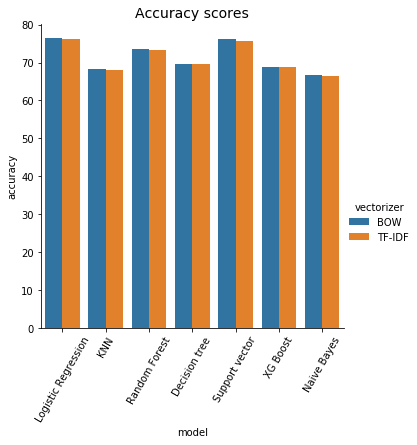

In [46]:
acc_chart=sns.factorplot(x='model', y='accuracy', hue='vectorizer', data=generic_results, kind='bar')
acc_chart.set_xticklabels(['Logistic Regression','KNN','Random Forest','Decision tree','Support vector','XG Boost','Naive Bayes'],rotation=60)
plt.title('Accuracy scores', fontsize=14)
plt.show()

### Election data set

In [92]:
results=pd.DataFrame(np.vstack([np.array(y1),predictions,np.array(elec_tweets['political_party'])]).T,columns=['Actual','Predicted','Party'])
results['True/False']=['True' if results['Actual'][i]==results['Predicted'][i] else 'False' for i in results.index ]
results.head()

,Actual,Predicted,Party,True/False
0,0,0,conservative,True
1,4,4,none,True
2,0,4,liberal,False
3,4,0,none,False
4,0,4,liberal,False


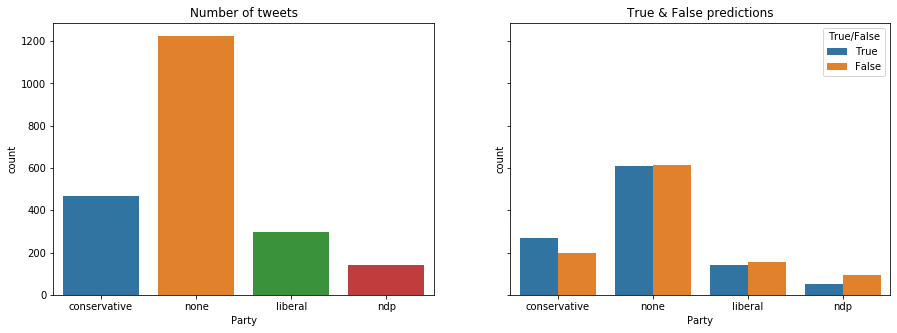

In [97]:
fig, (a1, a2) = plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)

sns.countplot(x='Party',data=results, ax=a1)
a1.set_title('Number of tweets')

sns.countplot(x='Party',hue='True/False',data=results, ax=a2)
a2.set_title('True & False predictions')

plt.show()

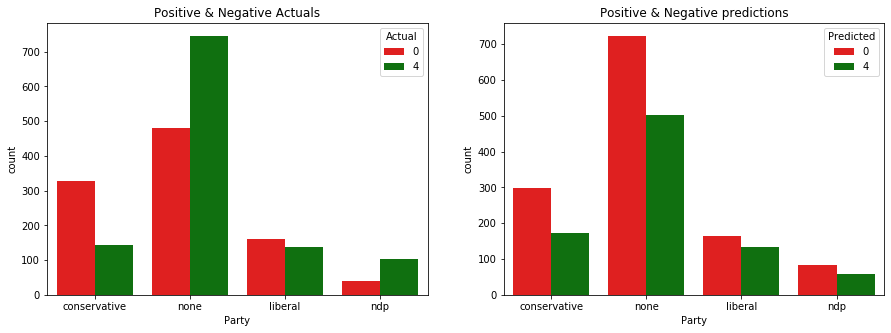

In [106]:
fig, (a3, a4) = plt.subplots(1,2,figsize=(15,5))

sns.countplot(x='Party', hue='Actual', data=results, palette=['red','green'], ax=a3)
a3.set_title('Positive & Negative Actuals')

sns.countplot(x='Party', hue='Predicted', data=results, palette=['red','green'], ax=a4)
a4.set_title('Positive & Negative predictions')

plt.show()

The accuracy of the best model of generic tweets on election data set is 50.13% So the prediction is very ambiguous. This NLP model cannot be relayed upon for predicting the winner of the election but this can be used to find out the people's opinion about a party to some extent, if they are positive or negative towards its government. 

From exploratory data analysis section, positive tweets to negative tweets count of parties are, Conservative: 0.44, Liberal: 0.88, NDP: 2.38, which shows people are negative towards conservative party and neutral to liberal. Though the positivity is more towards NDP, number of tweets are very less for NDP which indicates less followers. So, liberal has probability of winning which was ture as per real senario of 2019 elections.

But the predictions of our model shows that even NDP has more number of negative followers than positive which is contradicting the actual statistics. Upon seeing the predictions in the graph, it can be seen that all parties are viewed negatively.

By plotting word clouds and deep learning algorithms we can also check what is the root cause of positivity or negativity.
We can improve accuracy by using N-gram features, parameters tuning which is done in bonus section.

Further, not using stop words also resulted in increase of accuracy approximately by 2%. In the trial of removing stop words, there is a chance that some important contributers that help in sentiment prediction will be removed. But keeping in mind that analysing bulk data is computationally time consuming we remove stop words at the cost of trade-off in accuracy

### Negative tweets of election data set

In [111]:
elec_results=pd.DataFrame(y_testing)
elec_results['predicted']=list(predic_)
elec_results['reason']=label_encoder.inverse_transform(y_testing)
elec_results['predicted_reason']=label_encoder.inverse_transform(elec_results['predicted'])
elec_results['True/False']=['True' if (elec_results['negative_reason_coded'][i]==elec_results['predicted'][i]) else 'False' for i in elec_results.index]
elec_results.head()

,negative_reason_coded,predicted,reason,predicted_reason,True/False
1125,5,3,Scandal,Others,False
425,5,3,Scandal,Others,False
1550,5,3,Scandal,Others,False
1035,6,5,Women Reproductive right and Racism,Scandal,False
950,0,3,Climate Problem,Others,False


In [83]:
elec_results.groupby(['reason','True/False']).count().predicted

reason                               True/False
Climate Problem                      False          7
                                     True           2
Economy                              False         12
                                     True           6
Healthcare and Marijuana             False          4
Others                               False         26
                                     True          78
Privilege                            False          2
Scandal                              False         66
                                     True          88
Women Reproductive right and Racism  False          8
                                     True           3
Name: predicted, dtype: int64

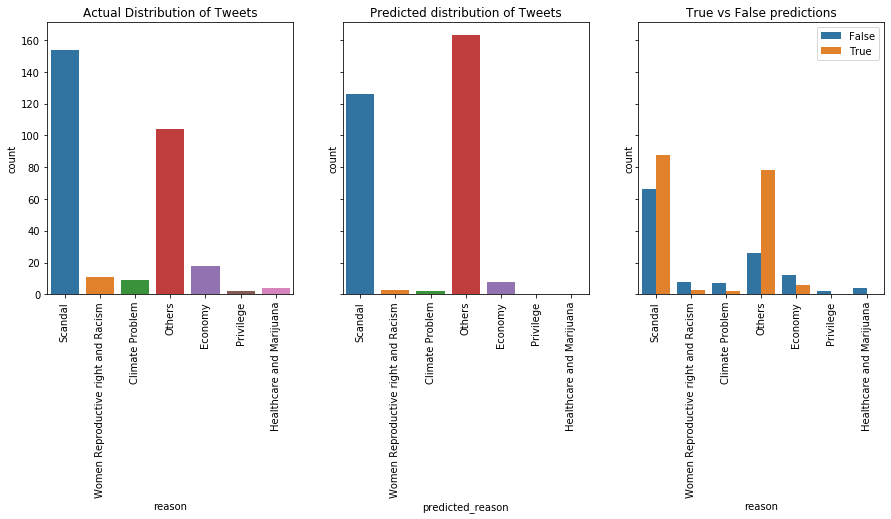

In [116]:
fig, (r1, r2, r3) = plt.subplots(1,3,figsize=(15,5),sharey=True)

sns.countplot(x='reason',data=elec_results, ax=r1)
r1.set_xticklabels(r1.get_xticklabels(),rotation=90)
r1.set_title('Actual Distribution of Tweets')

sns.countplot(x='predicted_reason',data=elec_results,order=elec_results['reason'].unique(), ax=r2)
r2.set_xticklabels(r2.get_xticklabels(),rotation=90)
r2.set_title('Predicted distribution of Tweets')

sns.countplot(x='reason',hue='True/False',data=elec_results, ax=r3)
r3.set_xticklabels(r3.get_xticklabels(),rotation=90)
r3.set_title('True vs False predictions')
r3.legend(loc=1)

plt.show()

In [117]:
elec_results['tweet']=elec_tweets.c_text[elec_results.index]
elec_results[elec_results.reason=='Privilege']

,negative_reason_coded,predicted,reason,predicted_reason,True/False,tweet
1157,4,5,Privilege,Scandal,False,canadian concern power non canadian peopl usa ...
548,4,1,Privilege,Economy,False,ye care underhand backroom deal let hear conse...


In [124]:
elec_results[elec_results.reason=='Healthcare and Marijuana'].iloc[0:2]

,negative_reason_coded,predicted,reason,predicted_reason,True/False,tweet
536,2,5,Healthcare and Marijuana,Scandal,False,next prime minist canada dentalcar that bad pa...
1710,2,5,Healthcare and Marijuana,Scandal,False,individu medic right freedom strip away vote p...


It can be observed that if the category have more entries, true predictions are more than the categories with less entries. This can be due to lack of sufficient number of samples in each category.

It can be seen that Privilege has very less entries and those are classified as scandal and economy which has more entries.
Basic ML models cannot distinguish the polarity and context of the text and thus leads to wrong prediction

###### 548: "Yes; who cares about underhanded backroom dealings? Let's hear more about the Conservatives' plan to put more $$s in the pockets of their CAPP buddies by removing the GST from home"

In the above statement, reason actually categorised as privilege, ML model may have observed many other tweets related to GST and $$ in Economy category and without getting in to actual context of tweet it predicts the tweet as Economy.

###### 536:'next prime minist canada dentalcar that bad pay pay foreign profit oil ga that realli bad good medicin suppos cost health polcan elxn43'

Though the above tweet is about dental care, words like foreign, profit which are more frequent as the tweets related to economy, scandal are more in the training set, the tweet is caategorized as scandal

If the categories are reduced further, the accuracy is observed to be more. But it is not done as the aim of the assignment is not to increase the accuracy. If the categories like women racism, privliege, health and climate problem are clubed, it accounts to 200nos sample size and also a better model can be tuned

## Bonus

###### Additional data exploration visuals

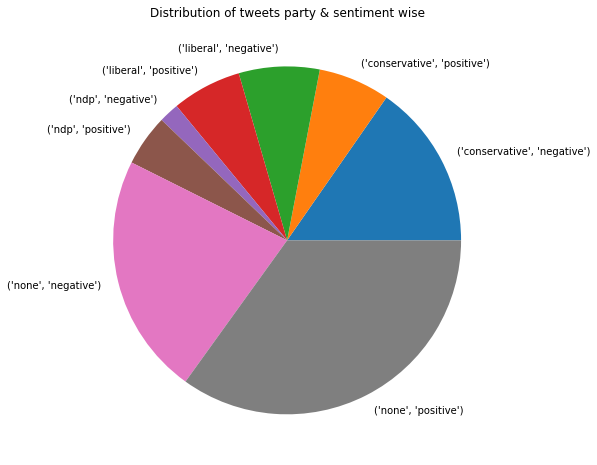

In [60]:
plt.figure(figsize=(8,8))
abc=elec_tweets.groupby(['political_party','sentiment']).count().text
plt.pie(abc,labels=abc.index)
plt.title('Distribution of tweets party & sentiment wise')
plt.show()

In [61]:
pos_e=[]
neg_e=[]
for i in elec_tweets.index:
    if elec_tweets['sentiment'][i]=='negative':
        neg_e.append(elec_tweets['c_text'][i])
    else:
        pos_e.append(elec_tweets['c_text'][i])
        
pos_etweet_con=pd.Series(pos_e).str.cat(sep=' ')
neg_etweet_con=pd.Series(neg_e).str.cat(sep=' ')

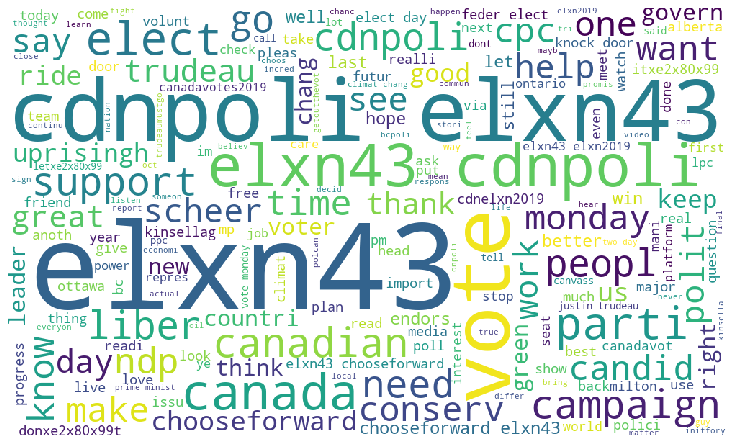

In [62]:
wordcloud_e = WordCloud(width = 1000, height = 600,background_color ='white',min_font_size = 10).generate(pos_etweet_con) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud_e) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

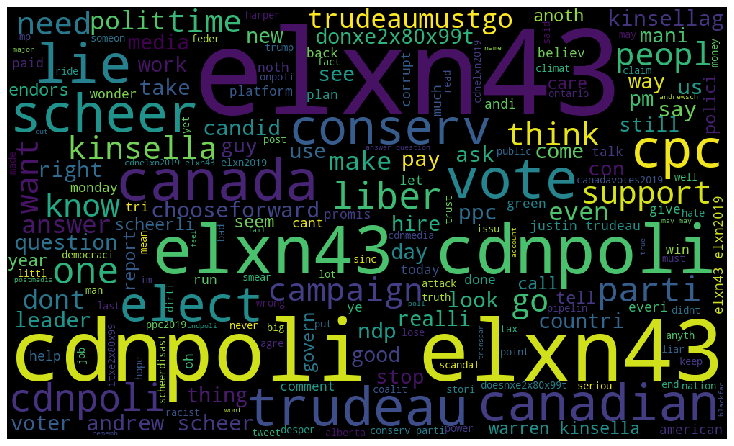

In [63]:
wordcloud_e = WordCloud(width = 1000, height = 600,min_font_size = 10).generate(neg_etweet_con) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud_e) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

From word clound of election data set, we can see that negative tweets both liberal and conservative party tags are poping up. We cannot come to conclusion from this type of clouds as the text size is not exaclty differentiable. 

Since the sample data is small this issue is faced.

#### Word embeddings
There are a lot of ways to use the word embedding as features, here we use joining (averaging) vectors from the words from sentence.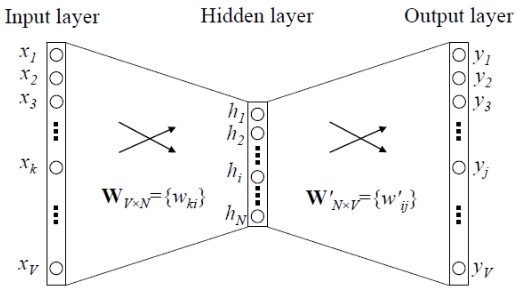

In [64]:
#Splitting the tweets into individual words for implementing word2vec
tokenized_sentences = [sentence.split() for sentence in generic_tweets_cleaned['cleaned_text']]
model = word2vec.Word2Vec(tokenized_sentences, size=100, min_count=1)

In [65]:
#word2vec generates vector for each word. Hence we avgerage the vectors of all words in a sentance to 1 vector that represents entire sentance
def buildWordVector(text, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    if text=='':
        vec=vec
    else:
        text = text.split(' ')
        for word in text:
            vec += model[word].reshape((1, size))
            count += 1.
        if count != 0:
            vec /= count
    return vec

In [66]:
#applying word2vec for generic tweets data set
X4 = np.concatenate([buildWordVector(z, 100) for z in generic_tweets_cleaned['cleaned_text']])

#Implementing logistic regression model on general tweets data
Xg_train, Xg_test, yg_train, yg_test = train_test_split(X4, y, random_state=200, test_size=0.3)
m_gen=LogisticRegression()
m_gen.fit(Xg_train,yg_train)
pred_g=m_gen.predict(Xg_test)
print('Accuracy on generic tweets data is {}%'.format(round(accuracy_score(pred_g,yg_test)*100,2)))

Accuracy on generic tweets data is 70.75%


In [67]:
#Splitting the election tweets into individual words for implementing word2vec
tokenized_sentences_elec = [sentence.split() for sentence in elec_model]
model = word2vec.Word2Vec(tokenized_sentences_elec, size=100, min_count=1)

#Implementing the above model on elections data set and comparing accuracy
X_elec = np.concatenate([buildWordVector(z, 100) for z in elec_model])
pred_elec=m_gen.predict(X_elec)
print('Accuracy of same model on elections tweets data is {}%'.format(round(accuracy_score(pred_elec,y1)*100,2)))

Accuracy of same model on elections tweets data is 52.84%


It can be seen that even the accuracy of word2vec on generic data is less than the best model (logistic regression using bag of words), it worked better on election data. 

This is because, word2vec considers the relation between words along with word frequency which is not a part of nither of bag of words not TF-IDF

In [68]:
#Using N-grams feature in vectorizer
vector_n = CountVectorizer(max_features =5000,ngram_range=(1,3))
X_n = vector_n.fit_transform(generic_tweets_cleaned['cleaned_text'])

#Implementing logistic regression model on general tweets data
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_n, y, random_state=200, test_size=0.3)
lr_n=LogisticRegression()
lr_n.fit(Xn_train,yn_train)
pred_n=lr_n.predict(Xn_test)
print('Accuracy on generic tweets data is {}%'.format(round(accuracy_score(pred_n,yn_test)*100,2)))

Accuracy on generic tweets data is 76.84%


In [69]:
#Splitting the election tweets into individual words for implementing N-grams
X_nelec = vector_n.fit_transform(elec_model)

#Implementing the above model on elections data set and comparing accuracy
pred_nelec=lr_n.predict(X_nelec)
print('Accuracy of same model on elections tweets data is {}%'.format(round(accuracy_score(pred_nelec,y1)*100,2)))

Accuracy of same model on elections tweets data is 53.16%


Accuracy of the model on generic data is better using N-grams as splits the sentence into group of words in sequence rather than just individual words. 

#### Hyperparameter tuning

On the best model which was Logistic regression using bag of words, we perform hyper parameter tuning to check the variation in accuracy if any. Hyperparameter tuning is done on negative tweets of elections data

In [130]:
param_grid={'C' :(0.001,0.01,0.05,0.1,0.5,1,5,10,100,1000),'solver' : ['newton-cg','sag', 'saga','lbfgs']}

lr = LogisticRegression(random_state=200)

random = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, cv = 3, n_jobs=-1, verbose=True)

random_result = random.fit(feature_data,target_data)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


In [131]:
print('Best score is {}%:'.format(round(random_result.best_score_*100,2)))
print('Best parameters are {}:'.format(random_result.best_params_))

Best score is 61.03%:
Best parameters are {'solver': 'newton-cg', 'C': 1000}:


It is observed that by hyperparameter tuning, the accuracy of the model is increased by 2%.(59% to 61.03%)
If not for accuracy, it is always a best practice to tune the parameters and model with best parameters